# WORK IN PROGRESS

- THIS DATA AND THIS MODEL ARE STILL BEING TRANSFORMED AND ASSESSED

In [1]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [2]:
#import dependecies
import pandas as pd
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("log_model").getOrCreate()

In [4]:
#read in training dataset
df = pd.read_csv('Resources/train_cleaned.csv')

In [5]:
df.head()

,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Credit_Card,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Payment_Behaviour,Monthly_Balance,Credit_Score
0,NaN,19114.12,1824.843333,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,,809.98,26.822620,22 Years and 1 Months,No,49.574949,High spent Small value payments,312.494089,Good
1,NaN,19114.12,NaN,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,NaN,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,Low spent Medium value payments,331.209863,Good
2,NaN,19114.12,NaN,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,Low spent Small value payments,223.451310,Good
3,NaN,19114.12,1824.843333,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,High spent Medium value payments,341.489231,Good
4,NaN,19114.12,NaN,4,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4.0,9.27,4.0,Good,809.98,27.262259,22 Years and 6 Months,No,49.574949,!@9#%8,340.479212,Good


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93465 entries, 0 to 93464
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SSN                       0 non-null      float64
 1   Annual_Income             93465 non-null  float64
 2   Monthly_Inhand_Salary     79447 non-null  float64
 3   Num_Credit_Card           93465 non-null  int64  
 4   Num_of_Loan               93465 non-null  int64  
 5   Type_of_Loan              82959 non-null  object 
 6   Delay_from_due_date       93465 non-null  int64  
 7   Num_of_Delayed_Payment    86910 non-null  float64
 8   Changed_Credit_Limit      91479 non-null  float64
 9   Num_Credit_Inquiries      91642 non-null  float64
 10  Credit_Mix                93465 non-null  object 
 11  Outstanding_Debt          93465 non-null  float64
 12  Credit_Utilization_Ratio  93465 non-null  float64
 13  Credit_History_Age        85026 non-null  object 
 14  Paymen

### Addressing the numerical columns with null values

- I will go through each numerical column and assess the best imputation method on a case by case basis

<Axes: ylabel='Frequency'>

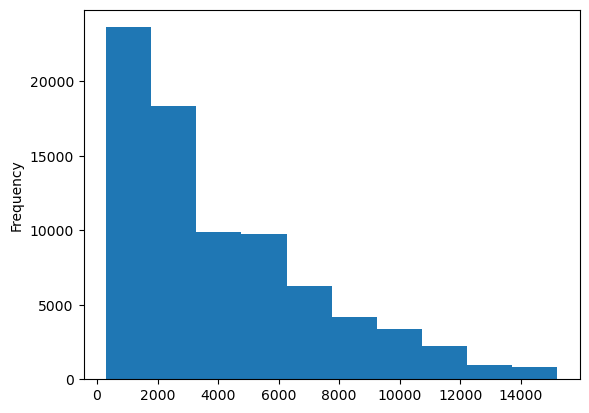

In [7]:
#histogram of feature with null values: Monthly_Inhand_Salary
df['Monthly_Inhand_Salary'].plot(kind='hist')

In [8]:
# replace null values for the 'Monthly_Inhand_Salary' with median value
median = df['Monthly_Inhand_Salary'].median()
df['Monthly_Inhand_Salary'].fillna(median, inplace = True)

4397.0


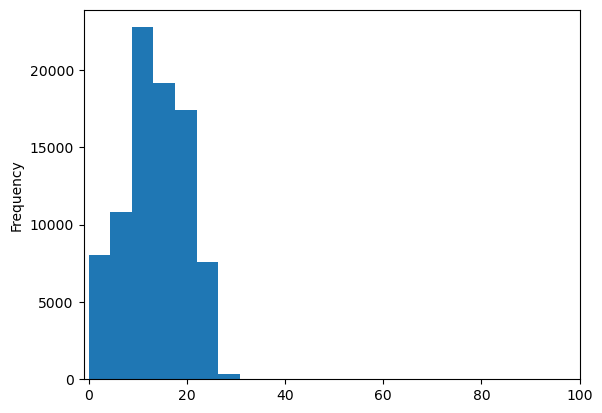

In [9]:
# histogram of feature with null values: Num_of_Delayed_Payment

# initial attempts to plot this histogram showed that it was skewed by a large outlier around at value 'max'
max = df['Num_of_Delayed_Payment'].max()

#set the limits of the graph to not display the outlier
df['Num_of_Delayed_Payment'].plot(kind ='hist', bins = 1000).set_xlim(-1, 100)
print(max)

In [10]:
# due to extremely high outlier in dataset, I will fill na values with the median
median = df['Num_of_Delayed_Payment'].median()
df['Num_of_Delayed_Payment'].fillna(median, inplace = True)

<Axes: ylabel='Frequency'>

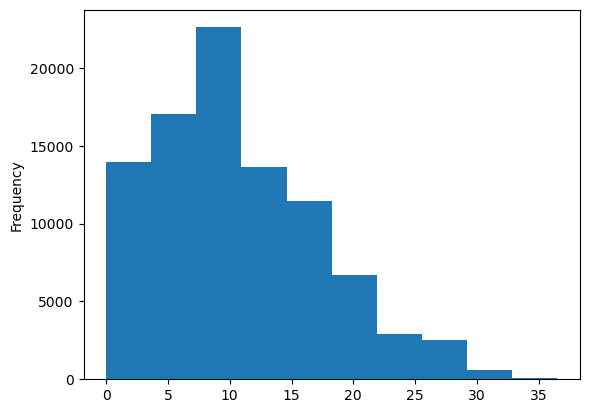

In [11]:
# histogram of feature with null values: Changed_Credit_Limit
df['Changed_Credit_Limit'].plot(kind = 'hist')

In [12]:
# replace null values with median due to skewed histogram
median = df['Changed_Credit_Limit'].median()
df['Changed_Credit_Limit'].fillna(median, inplace = True)

2597.0


(-1.0, 100.0)

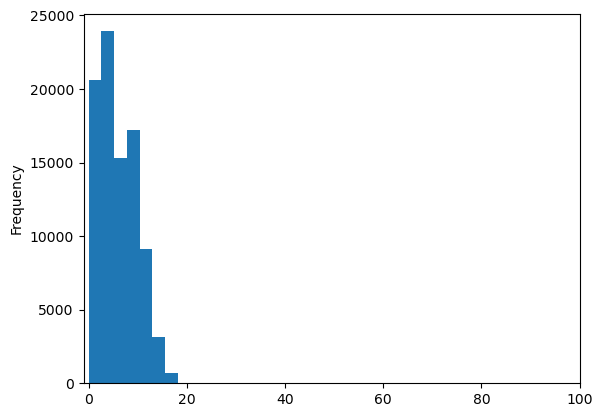

In [13]:
#  plot histogram of feature with null values: Num_Credit_Inquiries

# initial attempts to plot this histogram showed that it was skewed by a large outlier around at value 'max'
max = df['Num_Credit_Inquiries'].max()
print(max)

# set limits of x axis to exclude outlier
df['Num_Credit_Inquiries'].plot(kind = 'hist', bins = 1000).set_xlim(-1, 100)

In [14]:
#data is skewed with outliers so I will replace the na values with the median
median = df['Num_Credit_Inquiries'].median()
df['Num_Credit_Inquiries'].fillna(median, inplace = True)

<Axes: ylabel='Frequency'>

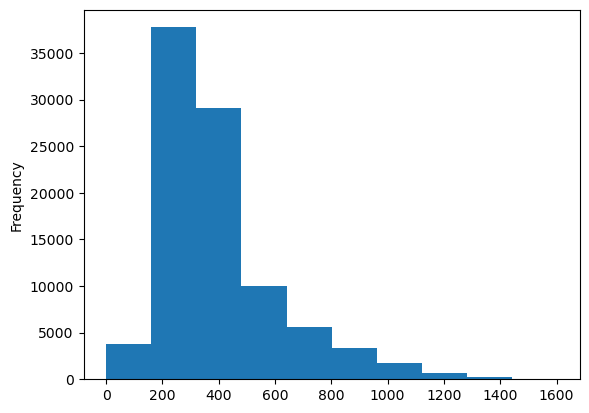

In [15]:
#  plot histogram of feature with null values: Monthly_Balance
df['Monthly_Balance'].plot(kind = 'hist')

In [16]:
#Data is skewed so i will fill na values with the median
median = df['Monthly_Balance'].median()
df['Monthly_Balance'].fillna(median, inplace = True)

### Addressing Categorical Columns
 - For now, I will drop all categorical columns and assess model performance with out them

In [17]:
#drop SSN column and categorical features
df.drop(['SSN', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour'], axis = 1, inplace = True)

In [18]:
#check dataframe
df.head()

,Annual_Income,Monthly_Inhand_Salary,Num_Credit_Card,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Total_EMI_per_month,Monthly_Balance,Credit_Score
0,19114.12,1824.843333,4,4,3,7.0,11.27,4.0,809.98,26.822620,49.574949,312.494089,Good
1,19114.12,3075.680000,4,4,3,7.0,9.57,4.0,809.98,28.609352,49.574949,331.209863,Good
2,19114.12,3075.680000,4,4,5,4.0,6.27,4.0,809.98,31.377862,49.574949,223.451310,Good
3,19114.12,1824.843333,4,4,6,14.0,11.27,4.0,809.98,24.797347,49.574949,341.489231,Good
4,19114.12,3075.680000,4,4,8,4.0,9.27,4.0,809.98,27.262259,49.574949,340.479212,Good


### Transforming the target variable
- I will encode the ordinal below target variable 

In [19]:
df['Credit_Score'].unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

In [20]:
#create ordered list from target column 'Credit_Score'
target_list = ['Poor', 'Standard', 'Good']

In [21]:
#split data into target and features

#This transforms the Credit_Score column into a 0 for poor, 1 for standard, and 2 for good
y = pd.Categorical(df['Credit_Score'], categories= target_list, ordered=True).codes

#create feature only df
X = df.drop(['Credit_Score'], axis = 1)

In [22]:
#split dateset in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Building the Logistic Regression Model
- Below I will fit, predict, score my inital model

In [31]:
#create log regression model
classifier = LogisticRegression(solver='newton-cg', random_state=1)
classifier

LogisticRegression(random_state=1, solver='newton-cg')

In [32]:
# Train the data
classifier.fit(X_train, y_train)

c:\Users\cpord\anaconda3\envs\dev\lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\cpord\anaconda3\envs\dev\lib\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\cpord\anaconda3\envs\dev\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(random_state=1, solver='newton-cg')

In [33]:
#make predictions
predictions = classifier.predict(X_test)

In [34]:
#print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.41      0.50      6875
           1       0.58      0.83      0.69     12452
           2       0.48      0.15      0.22      4040

    accuracy                           0.59     23367
   macro avg       0.56      0.46      0.47     23367
weighted avg       0.58      0.59      0.55     23367



### Initial Assessment and Fixes
- Accuracy is below goal of ~75%
- Transforming and using categorical variables in model may improve performance
- Numerical data needs to be scaled
- Creating training data with an equal amount of observations for each target may improve results.